<a href="https://colab.research.google.com/github/albogdan/aps360-project/blob/master/ResnetFeatureKernelOnBerend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchsummary import summary
import os
import time

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
if os.path.exists(os.path.expanduser('~/data')):
  !rm -rf {os.path.expanduser('~/data')}
!unzip '/content/drive/My Drive/Skule/!Year 3/S20 - APS360 (Intro to AI)/APS360 Project/share/BerendImages/mayacaptures.zip' -d {os.path.expanduser('~/data')}

Streaming output truncated to the last 5000 lines.
  inflating: /root/data/6232/6232 303R_1.png  
  inflating: /root/data/6232/6232 304L_1.png  
  inflating: /root/data/6232/6232 304R_1.png  
  inflating: /root/data/6232/6232 305L_1.png  
  inflating: /root/data/6232/6232 305R_1.png  
  inflating: /root/data/6232/6232 306L_1.png  
  inflating: /root/data/6232/6232 306R_1.png  
  inflating: /root/data/6232/6232 307L_1.png  
  inflating: /root/data/6232/6232 307R_1.png  
  inflating: /root/data/6232/6232 308L_1.png  
  inflating: /root/data/6232/6232 308R_1.png  
  inflating: /root/data/6232/6232 309L_1.png  
  inflating: /root/data/6232/6232 309R_1.png  
  inflating: /root/data/6232/6232 310L_1.png  
  inflating: /root/data/6232/6232 310R_1.png  
  inflating: /root/data/6232/6232 311L_1.png  
  inflating: /root/data/6232/6232 311R_1.png  
  inflating: /root/data/6232/6232 312L_1.png  
  inflating: /root/data/6232/6232 312R_1.png  
  inflating: /root/data/6232/6232 313L_1.png  
  inflati

In [ ]:
# Transform Settings - resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                     transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor()])

# define dataloader parameters
num_workers = 4
batch_size = 1

# get dataset
image_set = datasets.ImageFolder(os.path.expanduser('~/data'), transform=data_transform)

# put data inside loader
loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size, 
                                        num_workers=num_workers, shuffle=False)


In [ ]:
print(image_set.class_to_idx)
classes = os.listdir(os.path.expanduser('~/data'))
classes.sort()
classes = classes[:]
print(classes)

{'11211': 0, '15571': 1, '22388': 2, '2456': 3, '3001': 4, '3003': 5, '3004': 6, '3007': 7, '3008': 8, '3009': 9, '30136': 10, '3039': 11, '3040': 12, '3044c': 13, '3062b': 14, '35464': 15, '3659': 16, '3660': 17, '3665': 18, '3941': 19, '4070': 20, '42023': 21, '4589b': 22, '4727': 23, '4733': 24, '50950': 25, '54200': 26, '6111': 27, '6232': 28, '6249': 29, '6541': 30, '85984': 31, '87081': 32, '87087': 33, '98100': 34}
['11211', '15571', '22388', '2456', '3001', '3003', '3004', '3007', '3008', '3009', '30136', '3039', '3040', '3044c', '3062b', '35464', '3659', '3660', '3665', '3941', '4070', '42023', '4589b', '4727', '4733', '50950', '54200', '6111', '6232', '6249', '6541', '85984', '87081', '87087', '98100']


# Getting features

In [ ]:
import torchvision.models
resnet = torchvision.models.resnet34(pretrained=True)
modules = list(resnet.children())[:-1]      # delete the last fc layer.
resnet = nn.Sequential(*modules)
### Now set requires_grad to false
for param in resnet.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
!rm -rf /root/features

In [ ]:
# if os.path.exists(os.path.expanduser('~/feature')):
  # !rm -rf {os.path.expanduser('~/feature')}
!unzip '/content/drive/My Drive/Skule/!Year 3/S20 - APS360 (Intro to AI)/APS360 Project/share/BerendImages/feature(2).zip' -d {os.path.expanduser('~/features')}

Streaming output truncated to the last 5000 lines.
  inflating: /root/features/root/feature/4589b/18248.tensor  
  inflating: /root/features/root/feature/4589b/18312.tensor  
  inflating: /root/features/root/feature/4589b/18318.tensor  
  inflating: /root/features/root/feature/4589b/18222.tensor  
  inflating: /root/features/root/feature/4589b/18075.tensor  
  inflating: /root/features/root/feature/4589b/18109.tensor  
  inflating: /root/features/root/feature/4589b/17884.tensor  
  inflating: /root/features/root/feature/4589b/18033.tensor  
  inflating: /root/features/root/feature/4589b/18395.tensor  
  inflating: /root/features/root/feature/4589b/17879.tensor  
  inflating: /root/features/root/feature/4589b/18329.tensor  
  inflating: /root/features/root/feature/4589b/17601.tensor  
  inflating: /root/features/root/feature/4589b/18372.tensor  
  inflating: /root/features/root/feature/4589b/17857.tensor  
  inflating: /root/features/root/feature/4589b/18098.tensor  
  inflating: /root/

In [ ]:
!mv /root/features/root/feature/* /root/features/

In [ ]:
!rm -rf /root/feature

In [ ]:
feature_root_path = os.path.expanduser('~/feature')
for i in classes:
  path = os.path.join(feature_root_path, i)
  if not os.path.exists(path):
    !mkdir -p {path}

In [ ]:
# generate and save feature maps
i = 0
for img, label in loader:
  features = resnet.forward(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  features_folder_path = os.path.join(feature_root_path, classes[label])
  feature_path = os.path.join(features_folder_path, "{}.tensor".format(i))
  torch.save(features_tensor.squeeze(0), feature_path)
  i += 1
  print("saved {} images".format(i))

Streaming output truncated to the last 5000 lines.
saved 23002 images
saved 23003 images
saved 23004 images
saved 23005 images
saved 23006 images
saved 23007 images
saved 23008 images
saved 23009 images
saved 23010 images
saved 23011 images
saved 23012 images
saved 23013 images
saved 23014 images
saved 23015 images
saved 23016 images
saved 23017 images
saved 23018 images
saved 23019 images
saved 23020 images
saved 23021 images
saved 23022 images
saved 23023 images
saved 23024 images
saved 23025 images
saved 23026 images
saved 23027 images
saved 23028 images
saved 23029 images
saved 23030 images
saved 23031 images
saved 23032 images
saved 23033 images
saved 23034 images
saved 23035 images
saved 23036 images
saved 23037 images
saved 23038 images
saved 23039 images
saved 23040 images
saved 23041 images
saved 23042 images
saved 23043 images
saved 23044 images
saved 23045 images
saved 23046 images
saved 23047 images
saved 23048 images
saved 23049 images
saved 23050 images
saved 23051 images

In [ ]:
!zip feature.zip -r {feature_root_path}

Streaming output truncated to the last 5000 lines.
  adding: root/feature/30136/6347.tensor (deflated 15%)
  adding: root/feature/30136/6046.tensor (deflated 15%)
  adding: root/feature/30136/6381.tensor (deflated 15%)
  adding: root/feature/30136/5870.tensor (deflated 15%)
  adding: root/feature/30136/5718.tensor (deflated 15%)
  adding: root/feature/30136/6256.tensor (deflated 15%)
  adding: root/feature/30136/5767.tensor (deflated 15%)
  adding: root/feature/30136/6276.tensor (deflated 15%)
  adding: root/feature/30136/5827.tensor (deflated 15%)
  adding: root/feature/30136/5770.tensor (deflated 15%)
  adding: root/feature/30136/6114.tensor (deflated 15%)
  adding: root/feature/30136/5626.tensor (deflated 15%)
  adding: root/feature/30136/5946.tensor (deflated 15%)
  adding: root/feature/30136/6215.tensor (deflated 15%)
  adding: root/feature/30136/5914.tensor (deflated 15%)
  adding: root/feature/30136/6391.tensor (deflated 15%)
  adding: root/feature/30136/5648.tensor (deflated 15

# training code

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(model, loader, criterion):
  total_loss = 0.0
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      imgs, labels = data
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      output = model(imgs)

      # select index with maximum prediction score
      pred = output.max(1, keepdim = True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
      total_loss += criterion(output, labels).item()
  return 1 - correct/total, total_loss

def plot_training_curve(path):
  """ Plots the training curve for a model run, given the csv files
  containing the train/validation error/loss.

  Args:
      path: The base path of the csv files produced during training
  """
  import matplotlib.pyplot as plt
  train_err = np.loadtxt("{}_train_err.csv".format(path))
  val_err = np.loadtxt("{}_val_err.csv".format(path))
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_val_loss.csv".format(path))
  plt.title("Train vs Validation Error")
  n = len(train_err) # number of epochs
  plt.plot(range(1,n+1), train_err, label="Train")
  plt.plot(range(1,n+1), val_err, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1,n+1), train_loss, label="Train")
  plt.plot(range(1,n+1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [ ]:
def transfer_train(model, batch_size = 32, num_epochs = 10, lr = 0.003, wd = 1e-5):
  torch.manual_seed(360)

  train_loader, val_loader, test_loader = feature_loader(feature_root_path, 0.6, 0.2, batch_size)

  # Initialize containers for error and loss
  train_err, train_loss, val_err, val_loss = [], [], [], []

  # set up optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = lr, 
                                 weight_decay=wd)

  start_time = time.time()

  for epoch in range(num_epochs):
    epoch_total = 0
    epoch_correct = 0
    epoch_loss = 0
    model.train()
    for feature, labels in iter(train_loader):

      # Enable GPU
      if use_cuda and torch.cuda.is_available():
        feature = feature.cuda()
        labels = labels.cuda()
      
      # zero parameter gradients
      optimizer.zero_grad()

      # forward pass, backward pass, and optimize
      out = model(feature)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      
      # mini batch statistics
      pred = out.max(1, keepdim = True)[1]
      epoch_correct += pred.eq(labels.view_as(pred)).sum().item()
      epoch_total += feature.shape[0]
      epoch_loss += loss.item()
    train_err.append(1 - (epoch_correct / epoch_total))
    train_loss.append(epoch_loss)
    a, b = evaluate(model, val_loader, criterion)
    val_err.append(a)
    val_loss.append(b)
    
    print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
    print ("train err: {:.4f}, train loss: {:.4f}".format(train_err[epoch], train_loss[epoch]))
    print ("validation err: {:.4f}, validation loss: {:.4f}".format(a, b))

    # save the current model state
    model_path = get_model_name(model.name, batch_size, lr, epoch)
    torch.save(model.state_dict(), model_path)
  
  print('Finished training in %6.2f s' % (time.time()-start_time))
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


# training classifier

In [ ]:
# function to load features
def feature_loader(feature_root_path, train_p, val_p, batch_size = 32):
  dataset = torchvision.datasets.DatasetFolder(feature_root_path,\
                                                 loader = torch.load, extensions = ('.tensor'))

  split = [int(train_p * len(dataset)), int(val_p * len(dataset))]
  split.append(len(dataset) - split[1] - split[0])

  train_set, val_set, test_set = torch.utils.data.random_split(dataset, split)
  num_workers = 4

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  return train_loader, val_loader, test_loader

In [ ]:
class TransferLearningNetDp3(nn.Module):
  def __init__(self, p=0.0):
    super(TransferLearningNetDp3, self).__init__()
    self.name = "tNetDp3"

    # self.fc1 = nn.Linear(512, 3600)
    # self.fc2 = nn.Linear(3600, 1200)
    # self.fc3 = nn.Linear(1200, 50)
    self.fc1 = nn.Linear(512, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 50)
    self.dropout = nn.Dropout(p=p)
  
  def forward(self, x):
    x = x.view(-1, 512)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = F.leaky_relu(self.fc3(x))
    x = self.fc4(x)
    x = self.dropout(x)
    return x

tNet = TransferLearningNetDp3()
summary(tNet, (512,1,1), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         131,328
            Linear-2                  [-1, 128]          32,896
            Linear-3                   [-1, 64]           8,256
            Linear-4                   [-1, 50]           3,250
           Dropout-5                   [-1, 50]               0
Total params: 175,730
Trainable params: 175,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.67
Estimated Total Size (MB): 0.68
----------------------------------------------------------------


In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp3(0.3)
transfer_train(tNetDp, batch_size=500, num_epochs=500, lr=0.0005)

Epoch 0 Finished.  Time per Epoch:   4.00 s 
train err: 0.9709, train loss: 129.6297
validation err: 0.9745, validation loss: 43.8354
Epoch 1 Finished.  Time per Epoch:   3.93 s 
train err: 0.9715, train loss: 125.6201
validation err: 0.9714, validation loss: 43.1420
Epoch 2 Finished.  Time per Epoch:   3.88 s 
train err: 0.9693, train loss: 124.7315
validation err: 0.9727, validation loss: 42.9085
Epoch 3 Finished.  Time per Epoch:   3.84 s 
train err: 0.9709, train loss: 124.6651
validation err: 0.9734, validation loss: 42.8418
Epoch 4 Finished.  Time per Epoch:   3.80 s 
train err: 0.9605, train loss: 124.4503
validation err: 0.9736, validation loss: 42.6736
Epoch 5 Finished.  Time per Epoch:   3.78 s 
train err: 0.9598, train loss: 123.8078
validation err: 0.9409, validation loss: 42.4062
Epoch 6 Finished.  Time per Epoch:   3.77 s 
train err: 0.9478, train loss: 122.5892
validation err: 0.9257, validation loss: 41.3521
Epoch 7 Finished.  Time per Epoch:   3.76 s 
train err: 0.9272

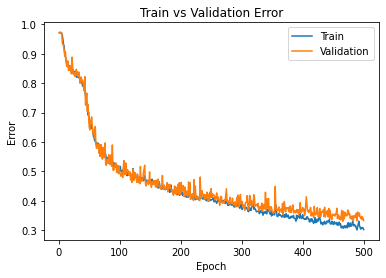

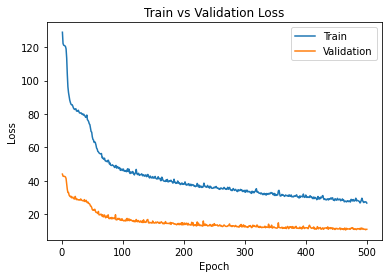

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 500, 0.0005, 499))

In [ ]:
# evaluate performance class by class
train_loader, valid_loader, test_loader = feature_loader(feature_root_path, 0.6, 0.2, batch_size = 1)
# load the data first
# the data had been previously copied into the workspace as small set
model = tNetDp
correct = 0
total = 0
correct_by_class = [0 for i in range(0, 35)]
total_per_class = [0 for i in range(0, 35)]
loader = valid_loader
model.eval()
with torch.no_grad():
  for i, data in enumerate(loader, 0):
    feature, labels = data

    output = model(feature)


    # select index with maximum prediction score
    pred = output.max(1, keepdim = True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    correct_by_class[labels] = correct_by_class[labels]\
                                + pred.eq(labels.view_as(pred)).sum().item()
    total += feature.shape[0]
    total_per_class[labels] += 1
print(correct_by_class)
print(total_per_class)
for i in range(0, 35):
  print("Class {}: {} out of {}, {}".format(classes[i], correct_by_class[i], 
                                            total_per_class[i],
                                            correct_by_class[i]/total_per_class[i]))
print(total)

[115, 101, 114, 112, 163, 130, 127, 103, 44, 102, 65, 103, 95, 80, 119, 95, 135, 102, 71, 148, 54, 87, 129, 159, 169, 110, 129, 90, 118, 125, 112, 122, 146, 17, 171]
[148, 164, 150, 166, 172, 151, 162, 153, 170, 162, 129, 174, 165, 178, 153, 159, 154, 157, 163, 163, 152, 151, 160, 163, 179, 166, 155, 146, 135, 164, 159, 171, 151, 174, 181]
Class 11211: 115 out of 148, 0.777027027027027
Class 15571: 101 out of 164, 0.6158536585365854
Class 22388: 114 out of 150, 0.76
Class 2456: 112 out of 166, 0.6746987951807228
Class 3001: 163 out of 172, 0.9476744186046512
Class 3003: 130 out of 151, 0.8609271523178808
Class 3004: 127 out of 162, 0.7839506172839507
Class 3007: 103 out of 153, 0.673202614379085
Class 3008: 44 out of 170, 0.25882352941176473
Class 3009: 102 out of 162, 0.6296296296296297
Class 30136: 65 out of 129, 0.5038759689922481
Class 3039: 103 out of 174, 0.5919540229885057
Class 3040: 95 out of 165, 0.5757575757575758
Class 3044c: 80 out of 178, 0.449438202247191
Class 3062b: 11

In [ ]:
correct = 0
total = 0
correct_by_class = [0 for i in range(0, 35)]
total_per_class = [0 for i in range(0, 35)]
loader = test_loader
model.eval()
with torch.no_grad():
  for i, data in enumerate(loader, 0):
    feature, labels = data

    output = model(feature)


    # select index with maximum prediction score
    pred = output.max(1, keepdim = True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    correct_by_class[labels] = correct_by_class[labels]\
                                + pred.eq(labels.view_as(pred)).sum().item()
    total += feature.shape[0]
    total_per_class[labels] += 1
print(correct_by_class)
print(total_per_class)
for i in range(0, 35):
  print("Class {}: {} out of {}, {}".format(classes[i], correct_by_class[i], 
                                            total_per_class[i],
                                            correct_by_class[i]/total_per_class[i]))
print(total)

[119, 91, 125, 100, 144, 126, 133, 84, 35, 90, 74, 90, 82, 67, 130, 95, 138, 97, 66, 165, 64, 88, 126, 162, 125, 90, 116, 104, 162, 123, 120, 114, 145, 17, 142]
[155, 153, 157, 159, 153, 155, 169, 154, 158, 153, 180, 147, 153, 156, 158, 158, 163, 143, 158, 180, 165, 167, 167, 167, 135, 149, 144, 157, 205, 150, 168, 164, 156, 183, 161]
Class 11211: 119 out of 155, 0.7677419354838709
Class 15571: 91 out of 153, 0.5947712418300654
Class 22388: 125 out of 157, 0.7961783439490446
Class 2456: 100 out of 159, 0.6289308176100629
Class 3001: 144 out of 153, 0.9411764705882353
Class 3003: 126 out of 155, 0.8129032258064516
Class 3004: 133 out of 169, 0.7869822485207101
Class 3007: 84 out of 154, 0.5454545454545454
Class 3008: 35 out of 158, 0.22151898734177214
Class 3009: 90 out of 153, 0.5882352941176471
Class 30136: 74 out of 180, 0.4111111111111111
Class 3039: 90 out of 147, 0.6122448979591837
Class 3040: 82 out of 153, 0.5359477124183006
Class 3044c: 67 out of 156, 0.42948717948717946
Class 